In [615]:
import pandas as pd
import numpy as np
import re
import requests
import seaborn as sns


In [616]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [617]:
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [618]:
# Заполняем пропуски
hotels = hotels.fillna(0)


In [619]:
#Удаляем дубликаты 
hotels = hotels.drop_duplicates()

___

### Ключевые правки

Получение месяца из года

In [620]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month
hotels['day'] = hotels['review_date'].dt.day


Количество дней как int

In [621]:
# Достаем количество дней c момента публикации ревью
def days_num(string_):
    regexp = re.findall(r'\d{0,5}', string_)
    return regexp[0]


hotels['days_since_review'] = hotels['days_since_review'].apply(days_num)
hotels['days_since_review'] = hotels['days_since_review'].astype('int')


Преобразование тегов

In [622]:
# Пркобразование к списку
def tag_reconstr(data):
    temp_list = []
    for i in data.split("'"):
        temp_list.append(i.strip())

    temp_list.remove('[')
    temp_list.remove(']')

    for i in temp_list:
        if i == ',':
            temp_list.remove(i)
    return temp_list


tags_series = hotels['tags'].apply(tag_reconstr)
hotels['tags'] = hotels['tags'].apply(tag_reconstr)


Количество ночей проведенные ревьюером в отеле

In [623]:
all_tags = tags_series.explode()
stayed_night_mask = all_tags.str.contains('Stayed', regex=False)
stayed_night = all_tags[stayed_night_mask]
stayed_night.str.split(' ')


def night_at_hotel(data):
    temp_var = 0
    for i in data.split(' '):
        try:
            temp_var = int(i)
        except ValueError:
            pass
    return temp_var


nights = stayed_night.apply(night_at_hotel)
nights = nights.rename('nights')
hotels = pd.concat([hotels, nights], axis=1)
hotels['nights'] = hotels['nights'].fillna(hotels['nights'].mode()[0])


In [624]:
top_tags = all_tags.value_counts()[:11]
mask = top_tags.index.str.contains('Stayed', regex=False)
one_hot_columns = list(top_tags[~mask].index)

for element in one_hot_columns:
    hotels[element] = hotels['tags'].apply(lambda x: 1 if element in x else 0)


Код отеля по коду его страны

In [625]:
# Достаем код страны
response = requests.get('https://countrycode.org/')
country_code = pd.read_html(response.text)
country_code = country_code[0]
country_code = country_code[['COUNTRY', 'COUNTRY CODE']]

# Создаем функцию для формирования кодовой строки исходя из принципа территориальной близости принадлежности для кодов формата Х-ХХХ


def get_code(data):
    data = data.split('-')
    return int(data[0])


country_code['COUNTRY CODE'] = country_code['COUNTRY CODE'].apply(get_code)


In [626]:
# Формируем новый закодированный (в последствие) признак местоположения отеля
hotels['hotel_country'] = hotels['hotel_address'].str.split(' ')
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: x[-2::])
hotels['hotel_country'] = hotels['hotel_country'].apply(
    lambda x: x[0]+' '+x[1] if x[0] == 'United' else x[1])

hotels = hotels.merge(
    country_code, how='left',
    left_on='hotel_country', right_on='COUNTRY'
)
hotels = hotels.rename(columns={'COUNTRY CODE': 'hotel_country_code'})


In [627]:
#Создаем признак города
hotels['city'] = hotels['hotel_address'].str.split(' ')
hotels['city'] = hotels['city'].apply(lambda x: x[-5] if x[-1] == 'Kingdom' else x[-2])
hotels.head()


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,Submitted from a mobile device,Couple,Solo traveler,Business trip,Group,Family with young children,hotel_country,COUNTRY,hotel_country_code,city
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,1,1,0,0,0,0,United Kingdom,United Kingdom,44,London
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,1,0,1,0,0,United Kingdom,United Kingdom,44,London
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,0,1,0,0,0,France,France,33,Paris
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,1,0,0,0,France,France,33,Paris
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,1,0,1,0,0,Netherlands,Netherlands,31,Amsterdam


In [628]:
#Кодируем отели
hotels['hotel_name'] = hotels['hotel_name'].astype('category')
hotels['hotel_name'] = hotels['hotel_name'].cat.codes

In [629]:
hotels.drop(['COUNTRY'], axis=1, inplace=True)


Страновый код ревьюера (показал плохой результат)

In [630]:
# Стрипуем национальность для будущего присвоения кода страны
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip()
# Переименуем пару стран
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(
    'United States of America', 'United States')

# Формируем новый фрейм с кодом страны ревьюера
hotels = hotels.merge(
    country_code, how='left',
    left_on='reviewer_nationality', right_on='COUNTRY'
)

hotels = hotels.rename(
    columns={'COUNTRY CODE': 'nationality_code', 'COUNTRY': 'reviewer_country'})

hotels['nationality_code'] = hotels['nationality_code'].fillna(
    hotels['nationality_code'].mode()[0])


"# Стрипуем национальность для будущего присвоения кода страны\nhotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip()\n# Переименуем пару стран\nhotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(\n    'United States of America', 'United States')\n\n# Формируем новый фрейм с кодом страны ревьюера\nhotels = hotels.merge(country_code, how='left',\n                      left_on='reviewer_nationality', right_on='COUNTRY')\nhotels = hotels.rename(\n    columns={'COUNTRY CODE': 'nationality_code', 'COUNTRY': 'reviewer_country'})\nhotels['nationality_code'] = hotels['nationality_code'].fillna(\n    hotels['nationality_code'].mode()[0])"

In [631]:
#hotels.drop(['reviewer_country'], axis=1, inplace=True)

Индекс популярности отеля по суммарному количеству появлений в датасете

In [632]:
# Датасет с количеством вхождений отеля
hotel_name = hotels['hotel_name'].value_counts()
hotel_name = pd.DataFrame(
    {'hotel_name': hotel_name.index, 'popularity': hotel_name.values})
hotels = hotels.merge(
    hotel_name, how='left',
    left_on='hotel_name', right_on='hotel_name'
)


/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_16800/732430017.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hotels.corr())


<AxesSubplot: >

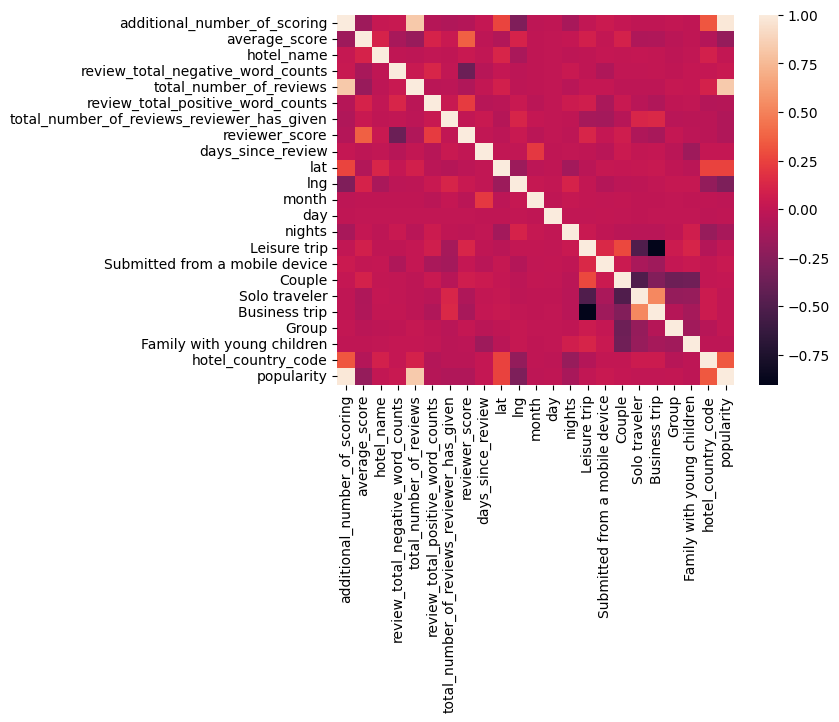

In [633]:

sns.heatmap(hotels.corr())

In [634]:
whole_corr = hotels.corr()[(hotels.corr() > 0.7) | (hotels.corr() < -0.7)]
whole_corr

/var/folders/1_/hgb3xg852md0hqqs3ybwbsp40000gn/T/ipykernel_16800/991658011.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  whole_corr = hotels.corr()[(hotels.corr() > 0.7) | (hotels.corr() < -0.7)]


,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,...,nights,Leisure trip,Submitted from a mobile device,Couple,Solo traveler,Business trip,Group,Family with young children,hotel_country_code,popularity
additional_number_of_scoring,1.000000,NaN,NaN,NaN,0.824494,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.983203
average_score,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hotel_name,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_total_negative_word_counts,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_number_of_reviews,0.824494,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.831310
review_total_positive_word_counts,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_number_of_reviews_reviewer_has_given,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_since_review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [635]:
#Список фитов с мультиколлинеарностью
direct_corr = whole_corr.count(axis=0)
corr_columns = pd.DataFrame({'Name':direct_corr.index, 'CNT':direct_corr.values})
corr_columns.query("CNT > 1")


,Name,CNT
0,additional_number_of_scoring,3
4,total_number_of_reviews,3
14,Leisure trip,2
18,Business trip,2
22,popularity,3


In [636]:
hotels.drop(['additional_number_of_scoring', 'popularity', 'Business trip'], axis=1, inplace=True)

### Мои признаки

In [637]:
'''# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'nights']
# , 'additional_number_of_scoring', 'popularity'

# категориальные признаки
cat_cols = [
    'day',
    'hotel_country_code',
    'month',
    'average_score',
    'lat', 'Leisure trip',
    'Submitted from a mobile device',
    'Couple',
    'Solo traveler',
    'Group',
    'Family with young children',
    'hotel_name'
]'''


In [ ]:
# непрерывные признаки
num_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts',]
# , 'additional_number_of_scoring', 'popularity'

# категориальные признаки
cat_cols = ['hotel_name', ]

In [638]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis=1, inplace=True)
hotels.drop(['review_date'], axis=1, inplace=True)


### Основное действо

In [639]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = hotels.drop(['reviewer_score'], axis=1)
y = hotels['reviewer_score']


In [640]:
'''
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts']

# категориальные признаки
cat_cols = ['average_score', 'lat']'''


"\n# непрерывные признаки\nnum_cols = ['total_number_of_reviews', 'review_total_negative_word_counts']\n\n# категориальные признаки\ncat_cols = ['average_score', 'lat']"

<AxesSubplot: >

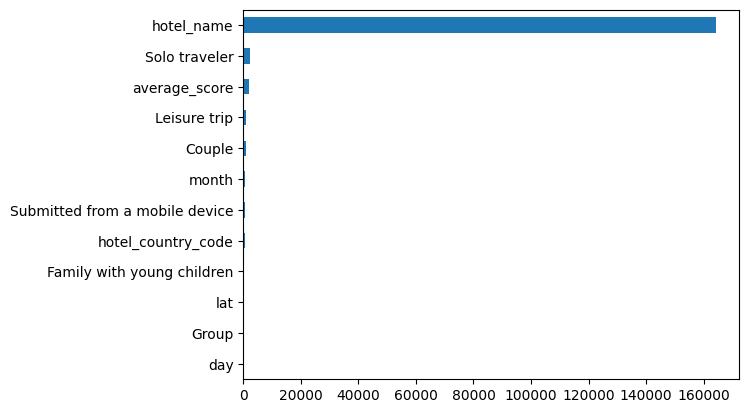

In [641]:
# Оценка влияния категориальных признаков на ключевую переменную
from sklearn.feature_selection import chi2  # хи-квадрат
y = y.astype('int')


imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')


<AxesSubplot: >

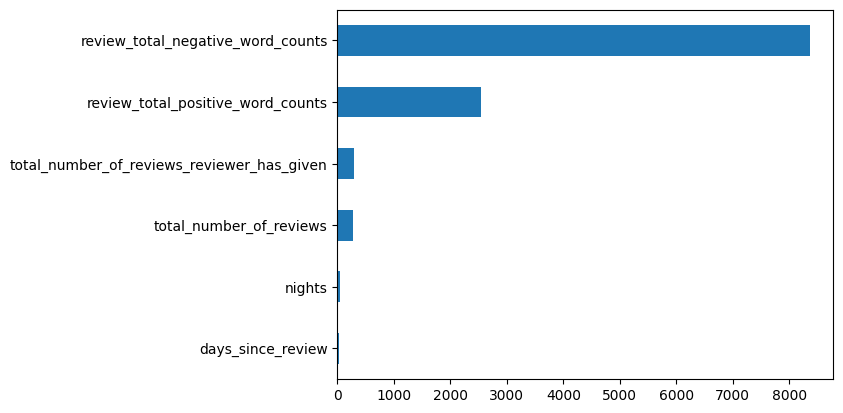

In [642]:
# Оценка влияния непрервных признаков на ключевую переменную
from sklearn.feature_selection import f_classif  # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')


In [643]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split


In [644]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [645]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)


In [648]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


MAPE: 0.1608676627419185


Небольшой бонус:


In [647]:
# # убираем признаки которые еще не успели обработать,
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)
